# Does rain impact stock returns?

The relationship between weather and stock returns has been studied many times already. But conclusions diverge. Some papers find statistically significant links, others don't. In this notebook, we will conduct our own analysis. We'll take the SP500 as a U.S. market proxy and we'll look at NYC weather since most investors trading U.S. equities are based there.

- For the weather data, we will use daily precipitation data from the Central Park (7 miles away from Wall Street) weather station in NYC. Data can be found on <a href="https://ncei.noaa.gov">ncei.noaa.gov</a>. and ranges from 1869 to today.
- For the stock market data, we will use daily SP500 returns. Data can be found on Yahoo Finance and ranges from 1928 to today.

### 0. Import libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import empyrical as ep
import quantstats as qs

sns.set_style('whitegrid')

### 1. Load and clean data

In [2]:
weather = pd.read_csv('data/weather.csv')
weather['Date'] = pd.to_datetime(weather['Date'])

sp500 = pd.read_csv('data/sp500.csv')
sp500['Date'] = sp500['Date'].apply(lambda x: x.split(' ')[0]) # remove time to keep only date
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500['LogReturn'] = np.log(sp500['Close']) - np.log(sp500['Close'].shift(1)) # calculate log return
sp500 = sp500.dropna() # drop first row with NaN

### 2. Merge dataframes

In [3]:
start_date = sp500['Date'].min()
end_date = sp500['Date'].max()

weather = weather[(weather['Date'] >= start_date) & (weather['Date'] <= end_date)] # we subset weather data to match the same period as sp500 data

merge = pd.merge(sp500, weather, how='inner', left_on='Date', right_on='Date')
df1 = merge[['Date', 'LogReturn', 'Precipitation']] # we only keep the columns we need
df1

,Date,LogReturn,Precipitation
0,1928-01-03,0.005647,0.0
1,1928-01-04,-0.002255,0.0
2,1928-01-05,-0.009640,0.0
3,1928-01-06,0.006248,0.0
4,1928-01-09,-0.009101,1.3
...,...,...,...
24119,2024-01-09,-0.001479,43.9
24120,2024-01-10,0.005650,5.6
24121,2024-01-11,-0.000671,0.0
24122,2024-01-12,0.000751,2.0


### 3. Quick data visualization

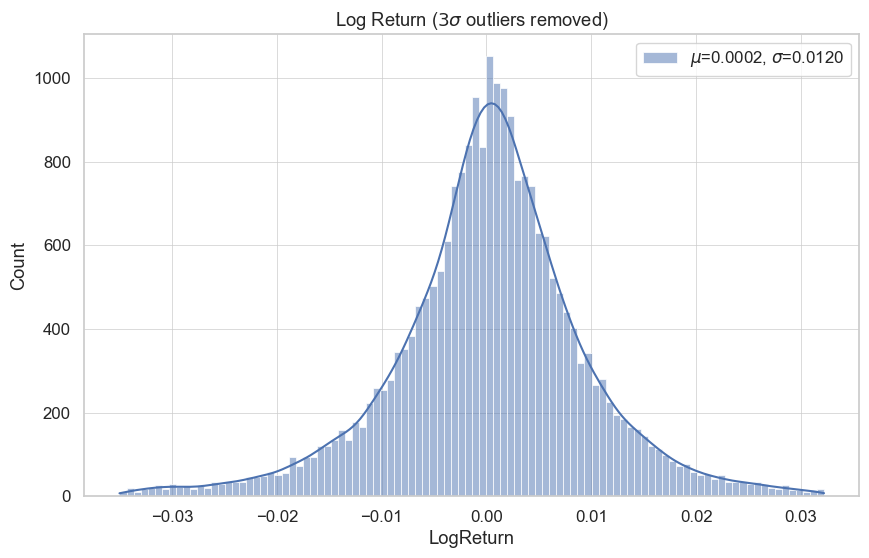

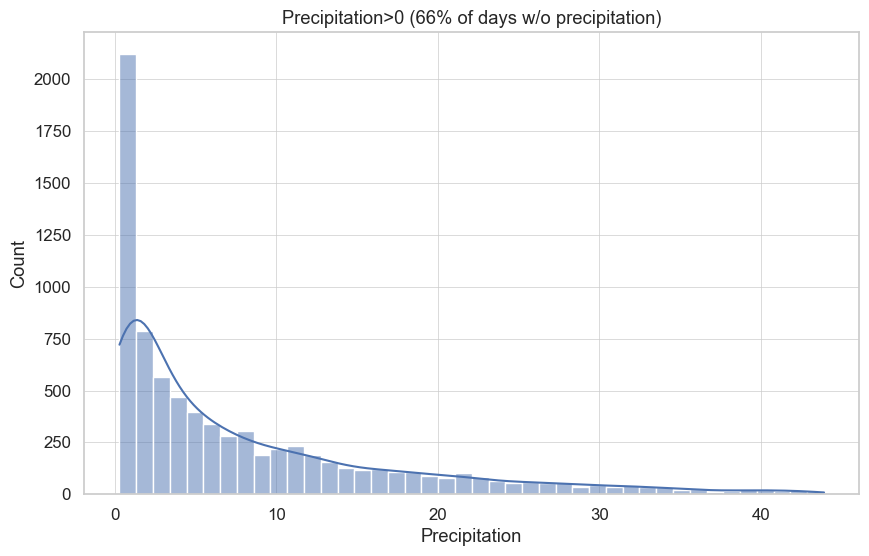

In [4]:
ret = df1['LogReturn']
precip = df1['Precipitation']

ret_no_outlier = ret[ret.between(ret.quantile(.01), ret.quantile(.99))]
mean_ret = ret.mean()
std_ret = ret.std()
precip_no_outlier = precip[precip.between(0.001, precip.quantile(.99))]
percent_no_precip = (precip==0).mean()

sns.histplot(ret_no_outlier, kde=True, label=f'$\mu$={mean_ret:.4f}, $\sigma$={std_ret:.4f}')
plt.legend()
plt.title(r'Log Return ($3\sigma$ outliers removed)')
plt.show()

sns.histplot(precip_no_outlier, kde=True)
plt.title(f'Precipitation>0 ({100*percent_no_precip:.0f}% of days w/o precipitation)')
plt.show()

### 4. Link between precipitation in NYC and SP500 returns

Let's first look at correlation.

In [5]:
corr = df1[['LogReturn', 'Precipitation']].corr()
print(f'Correlation between log return and precipitation: {corr.iloc[0,1]:.4f} i.e. when it rains, the stock market tends to go down!')

Correlation between log return and precipitation: -0.0026 i.e. when it rains, the stock market tends to go down!


In [6]:
ret_sign = np.sign(df1['LogReturn'])
is_rain = (df1['Precipitation'] > 0).astype(int)
df2 = pd.DataFrame({'Date': df1['Date'], 'SgnReturn': ret_sign, 'IsPrecipitation': is_rain})

corr = df2[['SgnReturn', 'IsPrecipitation']].corr()
print(f'Correlation between sign(returns) and precipitation: {corr.iloc[0,1]:.4f} i.e. when it rains, the stock market tends to go down!')

Correlation between sign(returns) and precipitation: -0.0132 i.e. when it rains, the stock market tends to go down!


### Is this link statistically significant?

Let's conduct a rigorous OLS regression of the form $\text{returns} = \beta \times \text{precipitation} + \alpha$ and see if we get a statistically significant $\beta$. As usual, we'll set our confidence level at 5% i.e. $2 \sigma$.

In [7]:
# linreg of LogReturns on Precipitation
X = df1['Precipitation']
X = sm.add_constant(X)
y = df1['LogReturn']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              LogReturn   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1653
Date:                Mon, 22 Jan 2024   Prob (F-statistic):              0.684
Time:                        09:25:50   Log-Likelihood:                 72495.
No. Observations:               24124   AIC:                        -1.450e+05
Df Residuals:                   24122   BIC:                        -1.450e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002    8.2e-05      2.968

We get a p-value much greater than 0.05, thus in this case $\beta$ is not statistically significant i.e; the level of precipitation in NYC does not constitute a statistically significant predictor of SP500 returns.

Interpretation: We might be asking too much. Instead of predicting returns from precipitation levels, let's simply try to predict the <b>sign</b> of SP500 returns based on whether it rains i.e. whether $\text{precipitation}>0$. We are thus predicting a categorical variable $\text{sgn(returns)}=\pm 1$ from a categorical variable $\text{IsPrecipitation}\in \lbrace 0, 1 \rbrace$. Let's therefore use logistic regression i.e. $\text{sgn(returns)}=h[\sigma(\beta\times\text{IsPrecipitation}+\alpha)\big]$ where $h=\textbf{1}_{\cdot>0.5}$.

In [8]:
# logreg of SgnReturns on IsPrecipitation
X = df2['IsPrecipitation']
X = sm.add_constant(X)
y = df2['SgnReturn'].apply(lambda x: 1 if x==1 else 0) # we need to convert the sign of returns to 0/1 (0 if negative, 1 if positive)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.691964
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:              SgnReturn   No. Observations:                24124
Model:                          Logit   Df Residuals:                    24122
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Jan 2024   Pseudo R-squ.:               0.0001233
Time:                        09:25:50   Log-Likelihood:                -16693.
converged:                       True   LL-Null:                       -16695.
Covariance Type:            nonrobust   LLR p-value:                   0.04242
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1124      0.016      7.100      0.000       0.081       0.143
IsPrecipitatio

This time, we get a p-value of 0.041<0.05, meaning that <b>there is a statistically significant link between SP500 returns and rain in NYC, for the 5% confidence level</b>.

Note that our p-value is >0.01 such that the null hypothesis $H_0: \text{"rain in NYC does not impact SP500 returns"}$ cannot be rejected under the 1% confidence level i.e. $3 \sigma$. We would need even more data to get to this level of confidence! (or we could find that we were unlucky and our correlation is in fact spurious)

In [9]:
y_pred = model.predict(X).apply(lambda x: 1 if x>=0.5 else 0)
acc = (y_pred == y).mean()
print(f'Accuracy of predicting growth: {100*acc:.2f}%')

Accuracy of predicting growth: 52.34%


In fact, our model always predicts $\text{sgn(returns)}=1$ because the mean of sign returns is $\mu \simeq 0.0598$ which is much greater than $\rho_\text{IsPrecipitation, Returns} \simeq -0.0132$ such that regardless of whether or not it rains, our model predicts positive returns. In other words, our signal is too weak to be properly tradable.

### 5. Trading on this alpha

We've found that there is a statistically significant link between rain in NYC and SP500 returns. Can we trade on this signal? We've seen that our signal is too weak, but we can still try to create a suboptimal signal just for the sake of the argument. The simplest strategy would be to short the SP500 when it's raining and long otherwise. Let's implement this strategy with various fractions $f$ of our initial capital (cf. Kelly criterion).

Note that we use the precipitation data of day $i$ to predict the returns of the same day $i$. This is an oversimplification. In practice, to implement this alpha in real life we could do two things:
1. the day before, try to forecast rain for the next day and take position accordingly at market close
2. on the day at market open, see if it rains and take position accordingly

Let's compare these two methods:
1. is probably more efficient but harder to implement since it requires us to predict rain, which does not seem trivial.
2. is much easier to implement but assumes that precipitations come before market open, when in fact they can happen whenever during market hours. At this point we would need hourly rain data (and market data) to take positions but this is beyond the scope of this notebook.

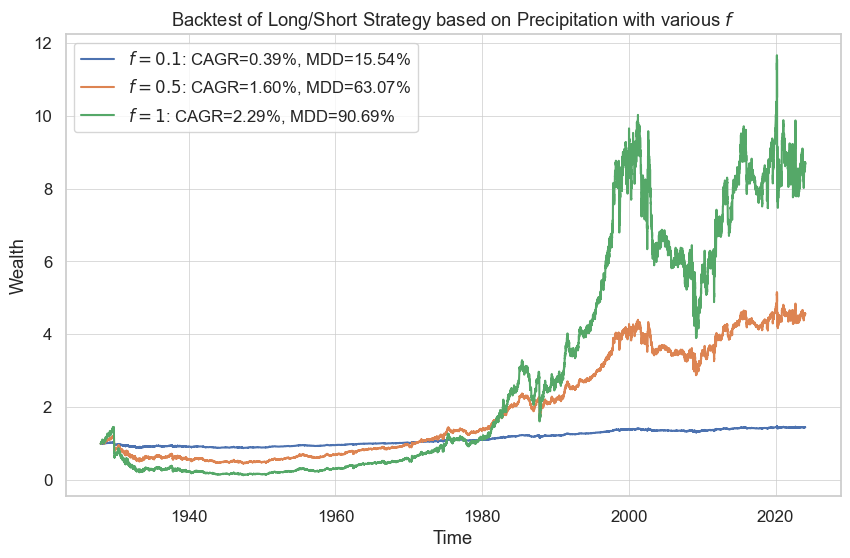

In [10]:
def backtest(positions, initial_capital, f):
    # f is the fraction of capital to invest at each time step
    wealth = [initial_capital]
    for i in range(len(positions)):
        current_wealth = wealth[-1]
        ret = df1['LogReturn'].iloc[i]
        pos = positions.iloc[i]
        new_wealth = (1-f)*current_wealth + f*current_wealth*(1+pos*ret)
        wealth.append(new_wealth)
    return wealth

initial_capital = 1
positions = model.predict(X).apply(lambda x: 1 if x>=0.52 else -1)
# when our model predicts a probability of growth > 52%, we go long, otherwise we go short
# this is suboptimal but demonstrates how we could try to trade on the precipitation signal
dates = df2['Date']

f_list = [0.1, 0.5, 1]
for f in f_list:
    wealth = backtest(positions, initial_capital, f)
    n_years = len(wealth)/252
    cagr = (wealth[-1]/wealth[0])**(1/n_years) - 1
    returns = pd.Series(wealth).pct_change().dropna()
    mdd = ep.max_drawdown(returns)
    plt.plot(dates, wealth[1:], label=f'$f={f}$: CAGR={100*cagr:.2f}%, MDD={-100*mdd:.2f}%')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.title(r'Backtest of Long/Short Strategy based on Precipitation with various $f$')
plt.show()

The most aggressive strategy ($f=1$) yields ~2.3% CAGR which results in multiplying our initial $1 almost tenfold over the investment period (~100 years). This is quite a remarkable performance given that we only use rain as signal! However this strategy is very volatile and has ~90% MDD which is unacceptable.

Less aggressive strategies have slower growth but are less risky. For instance, using $f=0.1$ we get ~0.4% CAGR and ~16% MDD which is weak but still remarkable for a strategy based on rain only!

### Is our strategy decorrelated from the market (i.e. does it have low beta)?

Since we're shorting the market when it rains, which is about 1/3 of the time, and we're long the rest of the time, we expect a correlation of about $\rho = \frac{2}{3}\times 1 + \frac{1}{3}\times -1 = \frac{1}{3}$. We do find this value below. Hence our strategy has market beta $\beta \simeq \frac{1}{3}$ which is rather unsatisfying since we always seek market-neutral strategies.

In [11]:
wealth = pd.Series(backtest(positions, initial_capital, f=1))
wealth_returns = (np.log(wealth) - np.log(wealth.shift(1))).dropna()
sp500_returns = df1['LogReturn']

corr = np.corrcoef(wealth_returns, sp500_returns)[0,1]
print(f'Correlation between strategy returns and S&P500 returns: {corr:.4f}')

Correlation between strategy returns and S&P500 returns: 0.3413


## Conclusion

In this notebook, we have proven the existence of a statistically significant link between the occurrence of rain in NYC and the sign of SP500 returns. This link holds up to 5% confidence level but not 1%. We backtested a simple strategy which consists in shorting the SP500 when there is rain and going long otherwise. This strategy is profitable although very risky and with little upside. Nevertheless, it illustrates that one can indeed use weather as a signal for trading!